# Multi-Asset Momentum Strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as st
import cvxpy as cvx
import statsmodels.api as sm
import KF_util as kf
import seaborn as sns
from empyrical import max_drawdown

plt.style.use('ggplot')
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Part 1: Data, Signal, Horizon

 - Get Data & Create Momentum Signals
 - Calculate weekly returns
 - Estimate weekly covariance
 - Define an equally-weighted benchmark
 - Get beta from Kalman Filter

(3638, 31)
['EQ_AUS', 'EQ_CAN', 'EQ_EUR', 'EQ_GBR', 'EQ_HKG', 'EQ_JPN', 'EQ_USA', 'EQ_DEU', 'EQ_FRA', 'EQ_ITA', 'EQ_ESP', 'AUD', 'CAD', 'EUR', 'GBP', 'JPY', 'NZD', 'ZAR', 'EUR_10Y', 'EUR_2Y', 'EUR_30Y', 'EUR_5Y', 'GBP_10Y', 'GBP_2Y', 'GBP_30Y', 'GBP_5Y', 'USD_10Y', 'USD_2Y', 'USD_30Y', 'USD_5Y', 'CASH']


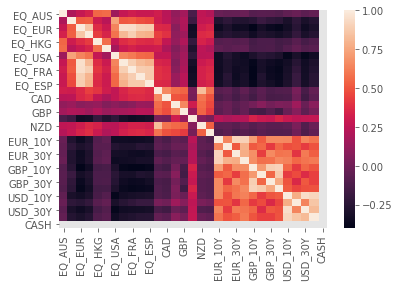

In [2]:
data = pd.read_csv('./Return_Source.csv', index_col=0)
data['CASH'] = 0
data.index = pd.to_datetime(data.index)
print(data.shape)
print(data.columns.tolist())

sns.heatmap(data.corr())

In [3]:
# cut backtest 

back_test_begin_date = pd.to_datetime('2004-01-01')
print(back_test_begin_date)

data_bt = data.loc[back_test_begin_date:, :]
print(data_bt.shape)

2004-01-01 00:00:00
(3196, 31)


In [4]:
# creat momentum signals:
# find integer w such that n/252 ~ 0.25, 0.5, 1 year
# exclude the most recent (n_lag=3) trading days to avoid short term reversals and allow lag implementations
# standardize the signal magnitude by taking the mean

n_lag = 3 # must be greater than 0

def get_week_end_signal(n_month, n_lag, date_begin=back_test_begin_date):
    
    w = int(252 * n_month / 12)
    s = data.shift(n_lag).rolling(w, min_periods=w, closed='right').mean()
    
    return s.loc[date_begin:, :].resample('W-FRI').last().dropna()

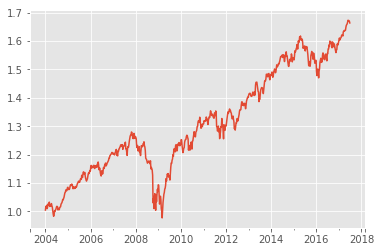

In [5]:
# create simple equally-weighted benchmark
# weekly rebalance, ignoring holidays

# helping function for weeking return calculation
agg_returns = lambda df: (1 + df).prod(axis=0) - 1

# translate return into cummulative equity curve
ret_to_EC = lambda r: (r + 1).cumprod()

ret_wk = data_bt.resample('W-FRI').apply(agg_returns)

bmark_ret = ret_wk.mean(axis=1)
bmark_EC = ret_to_EC(bmark_ret)
bmark_EC.plot()

In [6]:
# estimate covariance based on weekly returns
mom_wk = {'%dM'%m: get_week_end_signal(m, n_lag) for m in [3, 6, 12]}

V = data.resample('W-FRI').apply(agg_returns).ewm(halflife=52).cov() * 52
V = V.loc[back_test_begin_date:, slice(None)]

In [7]:
## KF Wrapper

def get_KF_beta(R, Rm, N, name):
    
    train_R, test_R = R.iloc[:N], R[N:]
    train_Rm, test_Rm = Rm.iloc[:N], Rm[N:]
    
    S, P, sys_params = kf.get_init_state_from_OLS(train_R, train_Rm)
    
    beta = kf.generalized_KF(test_R , sm.add_constant(test_Rm), S, P, sys_params)
    
    B = [pd.DataFrame(beta[:, i + 1], columns=[name], index=R.index[N:])
         for i in range(Rm.shape[1])]
        
    return B

def get_week_end_KF_beta(Rm, n_lag, date_begin=back_test_begin_date):
    
    N = data[:date_begin].shape[0] // 2
    B = [[] for i in range(Rm.shape[1])] 

    for c in data.columns[:-1]:
        res = get_KF_beta(data[c], Rm, N, c)
        for i in range(Rm.shape[1]): B[i].append(res[i])

    KF_beta = [pd.concat(b, axis=1).shift(n_lag).resample('W-FRI').last()[back_test_begin_date:].dropna() for b in B]
    
    # add CASH beta
    for i in range(Rm.shape[1]):
        KF_beta[i]['CASH'] = 0
    
    return KF_beta

KF_beta = get_week_end_KF_beta(data[['EQ_USA', 'EUR', 'USD_10Y']], n_lag)

# Part 2: Portfolio Optimization

Test with 3 strategies (v.s. benchmark):

1. Adaptive weights based on signal strengh (softmax activation)
2. Mean-variance like long-short portfolio
3. Beta neutral with respect to 3 major assets: US equities, US treasury, EUR/USD

In [8]:
def softmax_weight(sig, C=1, lamb=100):
    # lamb: smoothing constant
    E = np.exp(sig*lamb)
    return E / E.sum() * C

def momentum_strat_adap_weight(n_long, n_short, W_long, W_short, signals, sig_to_w=softmax_weight, ret=ret_wk):
    
    '''
    n_long, n_short: integer, number of asset classes to long/short
    W_long: float (>0), aggregated long weight
    W_short: float (<0), aggregated short weight
    
    singals: signal for asset allocation
    sig_to_w: a function convert signal into portfolio weight
    ret: returns for calculating performance
    
    RETURN: 
    W: asset weights
    R: portfolio returns
    '''
    
    assert(W_long + W_short - 1 < 1e-8)
    assert(signals.shape == ret.shape)
    
    idx_sort = signals.values.argsort(axis=-1)
    
    W = np.zeros_like(signals)
    
    if n_short != 0:
        for i in range(W.shape[0]):
            W[i, idx_sort[i, -n_long:]] = sig_to_w(signals.values[i, -n_long:], W_long)
            W[i, idx_sort[i, :n_short]] = sig_to_w(np.abs(signals.values[i, :n_short]), W_short)
    else:
        for i in range(W.shape[0]):
            W[i, idx_sort[i, -n_long:]] = sig_to_w(signals.values[i, -n_long:], W_long)
            
    W = pd.DataFrame(W, index=signals.index, columns=signals.columns)
    R = (W * ret).sum(axis=1)
    
    return W, R

In [9]:
# simple long-short strategy
def opt_long_short(signal, cov, target_risk, W_long):
    
    N = signal.shape[0]
    W = cvx.Variable(N)
    
    singal_term = cvx.sum_entries(cvx.mul_elemwise(signal, W))
    risk_term = cvx.quad_form(W, cov)
    L2_term = cvx.norm2(W)
    L1_term = cvx.norm(W, 1)

    obj = cvx.Maximize(singal_term - 0.05 * L1_term)
    constraints = [
        
        risk_term < target_risk ** 2,
        L2_term <= 0.75,
        cvx.sum_entries(W) == 1,
        
        cvx.sum_entries(cvx.pos(W)) <= W_long,
        
        W[-1] <= 0.1,
        W[-1] >= 0,
        
        cvx.sum_largest(W, 1) < W_long * 0.2,
        cvx.sum_smallest(W, 1) > (1 - W_long) * 0.2,
        cvx.sum_largest(W, 20) < W_long,
        cvx.sum_smallest(W, 10) > (1 - W_long),
        
    ]

    prob = cvx.Problem(obj, constraints)
    prob.solve(solver='ECOS')
    if W.value is None: print(prob.status)
    
    # get rid of tiny weights
    w = W.value.reshape(-1).round(4)
    w[w > 0] = w[w > 0] / w[w > 0].sum() * W_long
    w[w < 0] = w[w < 0] / w[w < 0].sum() * (1 - W_long)

    return w

# market neutral portfolio, set portfolio beta to targeted exposure level
def opt_market_neutral(signal, cov, target_risk, beta, beta_expo):
    
    N = signal.shape[0]
    W = cvx.Variable(N)
    
    singal_term = cvx.sum_entries(cvx.mul_elemwise(signal, W))
    risk_term = cvx.quad_form(W, cov)
    L2_term = cvx.norm2(W)
    L1_term = cvx.norm(W, 1)

    obj = cvx.Maximize(singal_term - 0.05 * L1_term)
    constraints = [
        
        risk_term < target_risk ** 2,
        L2_term <= 0.75,
        cvx.sum_entries(W) == 1,
        
        # cash holdings
        W[N - 1] <= 0.1,
        W[N - 1] >= 0,
    ]
    
    for i in range(len(beta)):
        constraints.append(cvx.sum_entries(cvx.mul_elemwise(beta[i], W)) == beta_expo)

    prob = cvx.Problem(obj, constraints)
    prob.solve(solver='ECOS')
    if W.value is None: print(prob.status)
    
    # get rid of tiny weights
    w = W.value.reshape(-1).round(4)
    w = w / w.sum()

    return w

In [10]:
def port_construct(signals, cov_mats, target_risk, optimizer, ret=ret_wk, **kwarg):
    
    '''
    singals: signal for asset allocation
    cov_mats: covariance of asset returns
    optimizer: function, opt_long_short OR opt_market_neutral
    target_risk: target 2nd moment of return
    ret: returns for calculating performance
    
    key word arguments:
    W_long: float (>0), aggregated long weight
    betas: beta estimation w.r.t each factor
    beta_expo: beta exposure
    
    RETURN: 
    W: asset weights
    R: portfolio returns
    '''
    
    assert(signals.shape == ret.shape)
    W = np.zeros_like(signals)
    
    for i, d in zip(range(W.shape[0]), cov_mats.index.get_level_values(0).unique()):
        
        C = cov_mats.loc[d, :].values
        S = 252 * signals.iloc[i, :].values
        
        if optimizer == opt_long_short:
            W[i, :] = optimizer(S, C, target_risk, kwarg['W_long'])

        if optimizer == opt_market_neutral:
            B = [beta.iloc[i, :].values for beta in kwarg['betas']]
            W[i, :] = optimizer(S, C, target_risk, B, kwarg['beta_expo'])
    
    W = pd.DataFrame(W, index=signals.index, columns=signals.columns)
    R = (W * ret).sum(axis=1)
    
    return W, R

## 1. Adaptive Weights - softmax activation

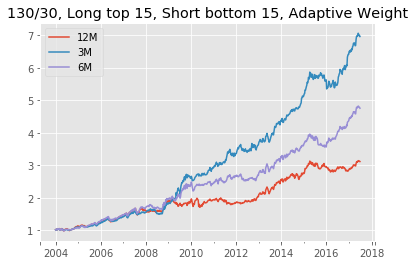

In [11]:
ret_adap_w = {k: momentum_strat_adap_weight(15, 15, 1.3, -.3, mom_wk[k])[1] for k in mom_wk.keys()}
EC_adap_w = {k: ret_to_EC(ret_adap_w[k]) for k in mom_wk.keys()}

pd.DataFrame(EC_adap_w).plot(title='130/30, Long top 15, Short bottom 15, Adaptive Weight')

## 2. Mean-Variance Long-short 130/30

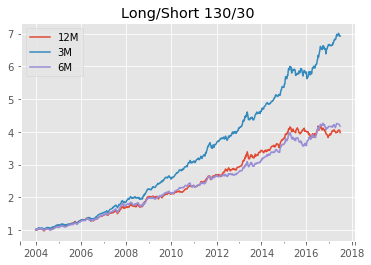

In [12]:
ret_ls_w = {k: port_construct(mom_wk[k], V, 0.07, opt_long_short, W_long=1.3)[1] for k in mom_wk.keys()}
EC_ls_w = {k: ret_to_EC(ret_ls_w[k]) for k in mom_wk.keys()}

pd.DataFrame(EC_ls_w).plot(title='Long/Short 130/30')

## 3. Beta neutral

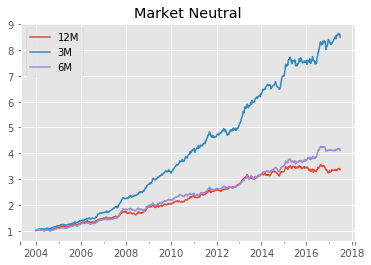

In [13]:
ret_mn_w = {k: port_construct(mom_wk[k], V, 0.07, opt_market_neutral, betas=KF_beta, beta_expo=0)[1] for k in mom_wk.keys()}
EC_mn_w = {k: ret_to_EC(ret_mn_w[k]) for k in mom_wk.keys()}

pd.DataFrame(EC_mn_w).plot(title='Market Neutral')

# Part 3: Performance Summary

 - Calculate Key Stats for plain strategy
 - Find best blend strategy
 - Calculate Key Stats for blend strategy
 - Compute correlation coefficient with other asset classes

In [14]:
def get_stats(r, name, ret=ret_wk):
    
    S = pd.Series(name=name)
    S.at['annual_ret'] = np.mean(r) * 52
    S.at['ret_std'] = np.std(r) * 52 ** 0.5
    S.at['SR'] = S['annual_ret'] / S['ret_std']
    S.at['skew'] = st.skew(r)
    S.at['ex_Kurt'] = st.kurtosis(r)
    S.at['win_rate'] = np.sum(r > 0) / r.shape[0]
    S.at['maxDD'] = max_drawdown(r)
    S.at['corr_EQ_USA'] = np.corrcoef(r, ret['EQ_USA'])[0][1]
    S.at['corr_USD_10Y'] = np.corrcoef(r, ret['USD_10Y'])[0][1]
    S.at['corr_EUR'] = np.corrcoef(r, ret['EUR'])[0][1]
    
    return S

## 1. Plain Strategy

In [15]:
all_ret = {'Equal_weigh': bmark_ret}
for k in mom_wk.keys():
    
    all_ret['Adap_w_' + k] = ret_adap_w[k]
    all_ret['LS_w_' + k] = ret_ls_w[k]
    all_ret['MN_w_' + k] = ret_mn_w[k]

single_horizon = pd.concat([get_stats(v, k) for k, v in all_ret.items()], axis=1).T
single_horizon.sort_values('SR', inplace=True)

single_horizon

,annual_ret,ret_std,SR,skew,ex_Kurt,win_rate,maxDD,corr_EQ_USA,corr_USD_10Y,corr_EUR
Equal_weigh,0.040008,0.069623,0.574643,-1.064312,11.845852,0.561702,-0.236570,0.820838,-0.061276,0.387663
Adap_w_12M,0.089946,0.110284,0.815589,-0.423626,3.189133,0.557447,-0.138668,0.184041,0.031387,0.074915
Adap_w_6M,0.120376,0.102584,1.173433,-0.118922,1.952496,0.590071,-0.112468,0.099354,0.027223,0.086844
MN_w_12M,0.091984,0.068473,1.343363,-0.216697,0.434252,0.607092,-0.088534,-0.011461,0.157114,0.003933
LS_w_12M,0.104659,0.073740,1.419288,-0.387517,0.753442,0.611348,-0.088444,0.007764,0.313402,0.088235
Adap_w_3M,0.148405,0.101142,1.467294,0.162256,2.877033,0.617021,-0.101332,0.163944,-0.012566,0.093437
LS_w_6M,0.108083,0.072460,1.491624,-0.249852,0.593820,0.604255,-0.103634,-0.051157,0.298424,0.097851
MN_w_6M,0.106746,0.069713,1.531222,-0.079934,0.656631,0.588652,-0.068105,-0.038804,0.164536,-0.032322
LS_w_3M,0.145165,0.066803,2.173046,-0.308481,0.665282,0.655319,-0.062449,-0.002124,0.319444,0.101742
MN_w_3M,0.160442,0.070145,2.287286,-0.079783,0.582173,0.641135,-0.052977,-0.046801,0.155805,-0.036572


## 2. Blend Strategy

In [16]:
# only blend with 2 different horizons
# find optimal weight to maximize in-sample sharpe ratio

def min_obj(lamb, R1, R2):
    
    R = lamb * R1 + (1 - lamb) * R2
    return -np.mean(R) / np.std(R) * 52 ** 0.5

def get_optimal_blend(horizon, ret, in_sample_end='20141231'):
    
    H1, H2 = horizon.split('/')
    R1, R2 = ret[H1], ret[H2]
    
    res = opt.minimize(min_obj, 0.5, args=(R1[:in_sample_end], R2[:in_sample_end]))
    W = np.array([res.x[0], 1 - res.x[0]]).round(4)
    print(horizon, W)
    print('In Sample SR: %.4f'%-res.fun)
    print('Out Sample SR: %.4f'%-min_obj(res.x[0], R1, R2))
    
    return R1 * W[0] + R2 * W[1], W

pairs = ['3M/6M', '3M/12M', '6M/12M']

print('\nAdaptive weight\n')
blend_ret_adap = {h: get_optimal_blend(h, ret_adap_w) for h in pairs}

print('\nLong Short\n')
blend_ret_ls = {h: get_optimal_blend(h, ret_ls_w) for h in pairs}

print('\nMarket Neutral\n')
blend_ret_mn = {h: get_optimal_blend(h, ret_mn_w) for h in pairs}


Adaptive weight

3M/6M [ 1.0197 -0.0197]
In Sample SR: 1.4759
Out Sample SR: 1.4656
3M/12M [0.9008 0.0992]
In Sample SR: 1.4834
Out Sample SR: 1.4728
6M/12M [0.9569 0.0431]
In Sample SR: 1.1353
Out Sample SR: 1.1716

Long Short

3M/6M [ 1.1392 -0.1392]
In Sample SR: 2.3510
Out Sample SR: 2.1787
3M/12M [0.9454 0.0546]
In Sample SR: 2.3427
Out Sample SR: 2.1716
6M/12M [0.4819 0.5181]
In Sample SR: 1.7351
Out Sample SR: 1.5380

Market Neutral

3M/6M [ 1.306 -0.306]
In Sample SR: 2.6005
Out Sample SR: 2.3166
3M/12M [ 1.0309 -0.0309]
In Sample SR: 2.5588
Out Sample SR: 2.2916
6M/12M [0.5513 0.4487]
In Sample SR: 1.7296
Out Sample SR: 1.5239


In [17]:
all_blend_ret = {'Equal_weigh': bmark_ret}
for k in pairs:
    all_blend_ret['MN_w_' + k] = blend_ret_mn[k][0]
    all_blend_ret['LS_w_' + k] = blend_ret_ls[k][0]
    all_blend_ret['Adap_w_' + k] = blend_ret_adap[k][0]

blend_horizon = pd.concat([get_stats(v, k) for k, v in all_blend_ret.items()], axis=1).T
blend_horizon.sort_values('SR', inplace=True)

blend_horizon

,annual_ret,ret_std,SR,skew,ex_Kurt,win_rate,maxDD,corr_EQ_USA,corr_USD_10Y,corr_EUR
Equal_weigh,0.040008,0.069623,0.574643,-1.064312,11.845852,0.561702,-0.236570,0.820838,-0.061276,0.387663
Adap_w_6M/12M,0.119064,0.101628,1.171564,-0.129618,1.967016,0.590071,-0.112721,0.104573,0.027762,0.087386
Adap_w_3M/6M,0.148957,0.101636,1.465588,0.166642,2.914296,0.615603,-0.102850,0.164385,-0.013292,0.093088
Adap_w_3M/12M,0.142606,0.096824,1.472838,0.041113,2.482386,0.612766,-0.092517,0.175062,-0.008278,0.096387
MN_w_6M/12M,0.100122,0.065702,1.523884,-0.179169,0.418190,0.607092,-0.062267,-0.028058,0.169716,-0.017068
LS_w_6M/12M,0.106309,0.069122,1.537998,-0.356454,0.798259,0.617021,-0.068985,-0.021552,0.323979,0.098201
LS_w_3M/12M,0.142954,0.065828,2.171618,-0.318555,0.669552,0.651064,-0.060995,-0.001563,0.325642,0.103008
LS_w_3M/6M,0.150327,0.068999,2.178691,-0.331528,0.960216,0.649645,-0.061380,0.005136,0.308704,0.097911
MN_w_3M/12M,0.162558,0.070935,2.291652,-0.080286,0.578878,0.643972,-0.054537,-0.047368,0.154146,-0.037400
MN_w_3M/6M,0.176873,0.076350,2.316608,-0.058652,0.602693,0.646809,-0.062384,-0.045313,0.140973,-0.034851


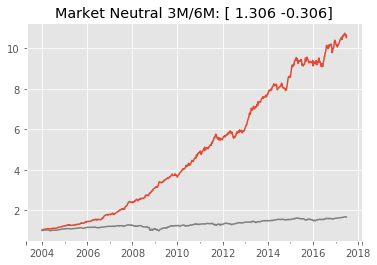

In [18]:
# plot the strategy with highest sharpe ratio v.s equally weighted benchmark

ret_to_EC(all_blend_ret['MN_w_3M/6M']).plot(title='Market Neutral 3M/6M: ' + str(blend_ret_mn['3M/6M'][1]))
bmark_EC.plot(color='gray')

In [19]:
# Calculate correlation with other asset classes

pd.concat([ret_wk, blend_ret_mn['3M/6M'][0]], axis=1).corr().iloc[:-2, -1]

EQ_AUS    -0.021904
EQ_CAN    -0.009547
EQ_EUR    -0.039454
EQ_GBR     0.005983
EQ_HKG     0.003532
EQ_JPN    -0.014692
EQ_USA    -0.045313
EQ_DEU     0.010735
EQ_FRA    -0.042310
EQ_ITA    -0.087265
EQ_ESP    -0.059469
AUD       -0.067358
CAD       -0.006781
EUR       -0.034851
GBP       -0.084758
JPY        0.062368
NZD       -0.050566
ZAR       -0.006420
EUR_10Y    0.223236
EUR_2Y     0.218253
EUR_30Y    0.207645
EUR_5Y     0.246088
GBP_10Y    0.243890
GBP_2Y     0.175675
GBP_30Y    0.214448
GBP_5Y     0.222553
USD_10Y    0.140973
USD_2Y     0.103591
USD_30Y    0.120954
USD_5Y     0.118467
Name: 0, dtype: float64

# Part 4: Lead-lag Effect

Given the optimal blend strategy's setting, investigate the lead-lag effect of the signals

In [20]:
blend_w = blend_ret_mn['3M/6M'][1]

def SR_lead_lag(n_lag):
    
    S_3M = get_week_end_signal(3, n_lag)
    S_6M = get_week_end_signal(6, n_lag)
    
    kf_beta = get_week_end_KF_beta(data[['EQ_USA', 'EUR', 'USD_10Y']], n_lag)
    r_wk = ret_wk.loc[S_3M.index, :]
    
    r_3M = port_construct(S_3M, V, 0.07, opt_market_neutral, ret=r_wk, betas=kf_beta, beta_expo=0)[1]
    r_6M = port_construct(S_6M, V, 0.07, opt_market_neutral, ret=r_wk, betas=kf_beta, beta_expo=0)[1]
    
    R = blend_w[0] * r_3M + blend_w[1] * r_6M
    
    return (np.mean(R) / np.std(R)) * (52 ** 0.5)

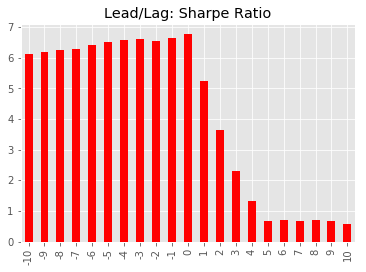

In [21]:
LL = np.vectorize(SR_lead_lag)(range(-10, 11))
pd.Series(LL, index=range(-10, 11)).plot.bar(color='r', title='Lead/Lag: Sharpe Ratio')